In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("MTA Turnstile Analysis") \
    .getOrCreate()


## Read data from the file

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = "/content/drive/MyDrive/MTA_Subway_Turnstile_Usage_Data__2022_20241130 (1).csv"  # Replace with your dataset path
turnstile_data = spark.read.csv(file_path, header=True, inferSchema=True)
#turnstile_data.show()
# Inspect the schema
turnstile_data.printSchema()

root
 |-- C/A: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- SCP: string (nullable = true)
 |-- Line Name: string (nullable = true)
 |-- Division: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Description: string (nullable = true)
 |-- Entries: integer (nullable = true)
 |-- Exits                                                     : integer (nullable = true)



# Data cleaning

In [4]:
# Rename columns for readability
turnstile_data = turnstile_data.withColumnRenamed("C/A", "ControlArea") \
                               .withColumnRenamed("UNIT", "Unit") \
                               .withColumnRenamed("SCP", "SubunitChannelPosition") \
                               .withColumnRenamed("DATE", "Date") \
                               .withColumnRenamed("TIME", "Time") \
                               .withColumnRenamed("ENTRIES", "Entries") \
                               .withColumnRenamed("Exits                                                     ", "Exits")

# Drop rows with missing values
turnstile_data = turnstile_data.dropna()

# Convert date to proper format
turnstile_data = turnstile_data.withColumn("Date", to_date(col("Date"), "MM/dd/yyyy"))

# Add a "Day of Week" column
turnstile_data = turnstile_data.withColumn("DayOfWeek", date_format(col("Date"), "EEEE"))


In [5]:
turnstile_data = turnstile_data.withColumn("Exits", regexp_replace(turnstile_data["Exits"], "[^0-9]", ""))

turnstile_data = turnstile_data.withColumn("Exits", trim(turnstile_data["Exits"]))


# Reading station mapper and mapping station column

In [30]:
# Load station mapping file (assuming it has columns C/A, UNIT, SCP, and Station)
station_mapping = spark.read.csv("/content/drive/MyDrive/Remote-Booth-Station.csv", header=True, inferSchema=True)
# Rename columns in station_mapping to match turnstile_data
station_mapping = station_mapping.withColumnRenamed("control_area", "ControlArea") \
                                 .withColumnRenamed("unit", "Unit") \
                                 .withColumnRenamed("subunit_channel_position", "SubunitChannelPosition")

# Join the datasets
turnstile_with_stations = turnstile_data.join(
    station_mapping,
    on=["ControlArea", "Unit"],
    how="left"
)

# Show the result
turnstile_with_stations.show(5)


+-----------+----+----------------------+---------+--------+----------+-------------------+-----------+-------+-------+---------+-------------+
|ControlArea|Unit|SubunitChannelPosition|Line Name|Division|      Date|               Time|Description|Entries|  Exits|DayOfWeek|      station|
+-----------+----+----------------------+---------+--------+----------+-------------------+-----------+-------+-------+---------+-------------+
|       A002|R051|              02-00-00|  NQR456W|     BMT|2022-12-30|2024-12-12 03:00:00|    REGULAR|7811029|2770909|   Friday|LEXINGTON AVE|
|       A002|R051|              02-00-00|  NQR456W|     BMT|2022-12-30|2024-12-12 07:00:00|    REGULAR|7811032|2770930|   Friday|LEXINGTON AVE|
|       A002|R051|              02-00-00|  NQR456W|     BMT|2022-12-30|2024-12-12 11:00:00|    REGULAR|7811067|2771080|   Friday|LEXINGTON AVE|
|       A002|R051|              02-00-00|  NQR456W|     BMT|2022-12-30|2024-12-12 15:00:00|    REGULAR|7811217|2771126|   Friday|LEXINGT

# Data Analysis

In [7]:
# Aggregate data
aggregated_data = turnstile_with_stations.groupBy("Station", "Date", "DayOfWeek") \
    .agg(
        sum("Entries").alias("TotalEntries"),
        sum("Exits").alias("TotalExits")
    )

# Sort data for visualization
aggregated_data = aggregated_data.orderBy(col("Date").desc())
aggregated_data.show()

+---------------+----------+---------+------------+---------------+
|        Station|      Date|DayOfWeek|TotalEntries|     TotalExits|
+---------------+----------+---------+------------+---------------+
|       RALPH AV|2022-12-30|   Friday|    38911121|    2.6332097E7|
|       GATES AV|2022-12-30|   Friday|    49471483|    2.1790353E7|
| CHRISTOPHER ST|2022-12-30|   Friday|   168729059|    1.3516891E8|
|      CHURCH AV|2022-12-30|   Friday|  7354065291|1.0443790722E10|
|         157 ST|2022-12-30|   Friday|    57938565|    6.6886564E7|
|    CHAMBERS ST|2022-12-30|   Friday| 24055803350|1.5661077357E10|
|CLINTON-WASH AV|2022-12-30|   Friday|  1064726325|   4.59714823E8|
| HOWARD BCH-JFK|2022-12-30|   Friday|    56325546|      5211851.0|
|         138 ST|2022-12-30|   Friday|  6010335943|  5.805227895E9|
|     BOYD-88 ST|2022-12-30|   Friday|    41251476|    1.4291085E7|
|     182-183 ST|2022-12-30|   Friday|  8948682295|1.1125247436E10|
|     TREMONT AV|2022-12-30|   Friday|  36457271

Data Processing

In [31]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, when

# Define a window specification
window_spec = Window.partitionBy("ControlArea", "Unit", "SubunitChannelPosition", "Station").orderBy("Date","Time")
turnstile_with_stations = turnstile_with_stations.withColumn("PrevEntries", lag("ENTRIES").over(window_spec).cast("integer")) \
                                                 .withColumn("PrevExits", lag("EXITS").over(window_spec).cast("integer"))

turnstile_with_stations = turnstile_with_stations.withColumn("ActualEntries",
    (col("ENTRIES") - col("PrevEntries")).cast("integer")) \
                                                 .withColumn("ActualExits",
    (col("EXITS") - col("PrevExits")).cast("integer"))

turnstile_with_stations = turnstile_with_stations.withColumn("ActualEntries",
    when((col("ActualEntries") >= 0) & (col("ActualEntries") <= 10000), col("ActualEntries")).otherwise(0)) \
                                                 .withColumn("ActualExits",
    when((col("ActualExits") >= 0) & (col("ActualExits") <= 10000), col("ActualExits")).otherwise(0))
turnstile_with_stations = turnstile_with_stations.dropna(subset=["station"])


#turnstile_with_stations.show()

Station summary

In [9]:

station_summary = turnstile_with_stations.groupBy("Station", "DATE").agg(
    sum("ActualEntries").alias("TotalEntries"),
    sum("ActualExits").alias("TotalExits")
)

station_summary.show(10, truncate=False)
station_summary.count()

+---------------+----------+------------+----------+
|Station        |DATE      |TotalEntries|TotalExits|
+---------------+----------+------------+----------+
|LEXINGTON AVE  |2022-04-15|4321        |4699      |
|LEXINGTON AVE  |2022-08-09|4312        |4959      |
|5 AV           |2022-01-01|2200        |2399      |
|5 AV           |2022-07-07|6301        |7478      |
|57 ST-7 AV     |2022-03-13|6243        |8620      |
|49 ST-7 AV     |2022-02-24|7917        |12081     |
|49 ST-7 AV     |2022-10-30|4881        |7622      |
|42 ST - TIMES S|2022-04-17|1945        |6680      |
|42 ST - TIMES S|2022-05-12|5233        |12223     |
|42 ST - TIMES S|2022-09-13|5411        |14121     |
+---------------+----------+------------+----------+
only showing top 10 rows



142027

In [10]:
station_summary.coalesce(1).write.csv("output_single_file", header=True, mode='overwrite')


Analyse monthly trends

In [32]:
from pyspark.sql.functions import month, year

turnstile_with_stations = turnstile_with_stations.withColumn("month", month("date"))
turnstile_with_stations = turnstile_with_stations.withColumn("year", year("date"))


In [12]:
monthly_stats = turnstile_with_stations.groupBy("station", "year", "month").agg(
    sum("ActualEntries").alias("TotalEntries"),
    sum("ActualExits").alias("TotalExits")
)


In [13]:
monthly_stats.show()

+---------------+----+-----+------------+----------+
|        station|year|month|TotalEntries|TotalExits|
+---------------+----+-----+------------+----------+
|42 ST - TIMES S|2022|    2|      110015|    253233|
| 28 ST-BROADWAY|2022|   12|      109465|    269362|
|    23 ST-5 AVE|2022|    3|      196605|    186229|
|  8 ST-BROADWAY|2022|    9|      134890|    247843|
|     NEWKIRK AV|2022|    7|      173034|    219956|
| BRIGHTON BEACH|2022|    2|      122892|    108924|
|      DEKALB AV|2022|   12|      274683|    314573|
|           8 AV|2022|    4|      368291|    453052|
|          71 ST|2022|    3|       76960|     35307|
|         121 ST|2022|    7|       34173|     16801|
| 59 ST-COLUMBUS|2022|    5|      765662|   1066105|
|       AQUEDUCT|2022|    2|       13676|      2387|
|  SEASIDE-B 105|2022|   11|        2696|      5346|
|   FAR ROCKAWAY|2022|    1|       51820|     78262|
|     174-175 ST|2022|    9|       56228|     51651|
|          46 ST|2022|    4|       93159|    1

In [14]:
monthly_stats.coalesce(1).write.csv("output_monthly_ridership", header=True, mode="overwrite")


Analyse daily trends

In [15]:
daily_stats = turnstile_with_stations.groupBy("station", "year", "month").agg(
    sum("ActualEntries").alias("total_entries"),
    sum("ActualExits").alias("total_exits"),
    countDistinct("date").alias("days_in_month")
)

daily_stats = daily_stats.withColumn("avg_daily_entries", round(daily_stats["total_entries"] / daily_stats["days_in_month"]))
daily_stats = daily_stats.withColumn("avg_daily_exits", round(daily_stats["total_exits"] / daily_stats["days_in_month"]))

In [16]:
daily_stats.show()

+---------------+----+-----+-------------+-----------+-------------+-----------------+---------------+
|        station|year|month|total_entries|total_exits|days_in_month|avg_daily_entries|avg_daily_exits|
+---------------+----+-----+-------------+-----------+-------------+-----------------+---------------+
| BRIGHTON BEACH|2022|    2|       122892|     108924|           28|           4389.0|         3890.0|
|          71 ST|2022|    3|        76960|      35307|           31|           2483.0|         1139.0|
|  SEASIDE-B 105|2022|   11|         2696|       5346|           30|             90.0|          178.0|
|           8 AV|2022|    4|       368291|     453052|           30|          12276.0|        15102.0|
|42 ST - TIMES S|2022|    2|       110015|     253233|           28|           3929.0|         9044.0|
|    23 ST-5 AVE|2022|    3|       196605|     186229|           31|           6342.0|         6007.0|
|  8 ST-BROADWAY|2022|    9|       134890|     247843|           30|     

Analyse hourly trends

In [17]:

hourly_stats = turnstile_with_stations.groupBy("station", hour(to_timestamp("time", "yyyy-MM-dd HH:mm:ss")).alias("hour")).agg(
    avg("ActualEntries").alias("total_entries"),
    avg("ActualExits").alias("total_exits")
)


In [18]:
hourly_stats = hourly_stats.orderBy("station")
hourly_stats.show(30)

+-------+----+-------------------+-------------------+
|station|hour|      total_entries|        total_exits|
+-------+----+-------------------+-------------------+
|  1 AVE|   8|  16.44305381727159| 126.62077596996245|
|  1 AVE|   9| 34.733333333333334| 248.46666666666667|
|  1 AVE|   7|  6.186645213193886| 52.905872888173775|
|  1 AVE|  18|  119.0909090909091| 187.27272727272728|
|  1 AVE|  20| 130.30918281381634| 236.05602358887953|
|  1 AVE|  19| 147.79133226324237|  219.3876404494382|
|  1 AVE|  15|  87.74660271782574| 171.71143085531574|
|  1 AVE|  23|   61.1634460547504| 139.89774557165862|
|  1 AVE|  11|  50.19632881085395|  288.0925778132482|
|  1 AVE|  13|               45.2|               95.8|
|  1 AVE|  14|  54.18181818181818|  131.0909090909091|
|  1 AVE|   4|  9.297331109257716| 31.423269391159298|
|  1 AVE|   3| 18.707630522088355| 40.443373493975905|
|  1 AVE|  16| 106.25715488215488| 191.67171717171718|
|  1 AVE|   5|0.05714285714285714|0.24285714285714285|
|  1 AVE| 

In [19]:
hourly_stats.coalesce(1).write.csv("peak_hours", header=True, mode='overwrite')


Create features for ML predictions

In [33]:
turnstile_with_stations = turnstile_with_stations.withColumn("Crowding", col("ActualEntries") + col("ActualExits"))
turnstile_with_stations = turnstile_with_stations.withColumn("Hour", hour(col("Time")))
turnstile_with_stations = turnstile_with_stations.withColumn("DayOfWeek", dayofweek(col("Date")))
turnstile_with_stations = turnstile_with_stations.withColumn(
    "DayHourInteraction", col("DayOfWeek") * col("Hour")
)
turnstile_with_stations = turnstile_with_stations.withColumn("LaggedCrowding", lag("Crowding").over(window_spec).cast("integer"))


In [34]:
# Aggregate data to calculate average crowding per day-hour combination
average_crowding = turnstile_with_stations.groupBy("DayOfWeek", "Hour").agg({"Crowding": "avg"}).withColumnRenamed("avg(Crowding)", "AvgDayHourCrowding")

# Join the aggregated feature back to the original DataFrame
turnstile_with_stations = turnstile_with_stations.join(average_crowding, on=["DayOfWeek", "Hour"], how="left")


In [22]:
turnstile_with_stations.show()

+---------+----+-----------+----+----------------------+---------+--------+----------+-------------------+-----------+-------+-----+-------------+-----------+---------+-------------+-----------+-----+----+--------+------------------+--------------+------------------+
|DayOfWeek|Hour|ControlArea|Unit|SubunitChannelPosition|Line Name|Division|      Date|               Time|Description|Entries|Exits|      station|PrevEntries|PrevExits|ActualEntries|ActualExits|month|year|Crowding|DayHourInteraction|LaggedCrowding|AvgDayHourCrowding|
+---------+----+-----------+----+----------------------+---------+--------+----------+-------------------+-----------+-------+-----+-------------+-----------+---------+-------------+-----------+-----+----+--------+------------------+--------------+------------------+
|        2|  19|       A002|R051|              02-05-01|  NQR456W|     BMT|2022-01-03|2024-12-12 19:00:00|    REGULAR|      0| 1025|LEXINGTON AVE|          0|     1022|            0|          3|  

In [35]:
turnstile_with_stations = turnstile_with_stations.dropna()
turnstile_with_stations = turnstile_with_stations.filter(col("station") == 'BRIGHTON BEACH')

In [36]:

# Categorize time into TimeCategory based on peak hours and weekends
turnstile_with_stations = turnstile_with_stations.withColumn(
    "TimeCategory",
    when((col("DayOfWeek") < 5) & (col("Hour").between(7, 9)), "Weekday_Morning_Peak")
    .when((col("DayOfWeek") < 5) & (col("Hour").between(17, 19)), "Weekday_Evening_Peak")
    .when(col("DayOfWeek") >= 5, "Weekend")
    .otherwise("Off_Peak")
)


In [25]:
turnstile_with_stations.printSchema()

root
 |-- DayOfWeek: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- ControlArea: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- SubunitChannelPosition: string (nullable = true)
 |-- Line Name: string (nullable = true)
 |-- Division: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Description: string (nullable = true)
 |-- Entries: integer (nullable = true)
 |-- Exits: string (nullable = true)
 |-- station: string (nullable = true)
 |-- PrevEntries: integer (nullable = true)
 |-- PrevExits: integer (nullable = true)
 |-- ActualEntries: integer (nullable = true)
 |-- ActualExits: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- Crowding: integer (nullable = true)
 |-- DayHourInteraction: integer (nullable = true)
 |-- LaggedCrowding: integer (nullable = true)
 |-- AvgDayHourCrowding: double (nullable = true)
 |-- TimeCategory: string (nul

Fit a Random Forest Regression model

In [40]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.ml.evaluation import RegressionEvaluator

# String Indexers for categorical variables

# division_indexer = StringIndexer(inputCol="Division", outputCol="DivisionIndex", handleInvalid="skip")
# #line_name_indexer = StringIndexer(inputCol="Line Name", outputCol="LineNameIndex", handleInvalid="skip")

# # One-Hot Encoders
# division_encoder = OneHotEncoder(inputCol="DivisionIndex", outputCol="DivisionVec")
# line_name_encoder = OneHotEncoder(inputCol="LineNameIndex", outputCol="LineNameVec")
time_category_indexer = StringIndexer(inputCol="TimeCategory", outputCol="TimeCategoryIndex", handleInvalid="skip")
time_category_encoder = OneHotEncoder(inputCol="TimeCategoryIndex", outputCol="TimeCategoryVec")

# Feature Assembler
assembler = VectorAssembler(
    inputCols=["Hour", "month","DayOfWeek","DayHourInteraction","AvgDayHourCrowding","PrevEntries","PrevExits","LaggedCrowding","TimeCategoryVec"],
    outputCol="features"
)

# Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="Crowding", seed=42)

# Pipeline
pipeline = Pipeline(stages=[time_category_indexer,
    time_category_encoder,
    assembler, rf
])

# Split data into training and test sets
turnstile_with_stations = turnstile_with_stations.orderBy("Date")
train_data, test_data = turnstile_with_stations.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate model
evaluator = RegressionEvaluator(labelCol="Crowding", predictionCol="prediction", metricName="r2")
r2_score = evaluator.evaluate(predictions)
print(f"R2 Score: {r2_score}")


R2 Score: 0.8606610279461713


In [41]:
# Access the trained Random Forest model
# Retrieve the categories from the OneHotEncoder stage
time_category_indexer = model.stages[0]
time_category_encoder = model.stages[1]

# Get the categories
time_category_labels = time_category_indexer.labelsArray[0]  # List of categories in their indexed order
time_category_columns = [f"TimeCategoryVec_{label}" for label in time_category_labels]

rf_model = model.stages[-1]  # Last stage in the pipeline is the RandomForestRegressor

# Get feature importances
importances = rf_model.featureImportances

# Get feature names from VectorAssembler
feature_list = assembler.getInputCols()+time_category_columns

# Create a mapping of feature names to importance scores
feature_importance = {feature_list[i]: importance for i, importance in enumerate(importances)}

# Display feature importances
print("Feature Importances:")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance}")


Feature Importances:
Hour: 0.11541054915697795
month: 0.0010878286410514932
DayOfWeek: 0.0037324082350584033
DayHourInteraction: 0.0683259052031949
AvgDayHourCrowding: 0.27444801762774795
PrevEntries: 0.12642636664424536
PrevExits: 0.1382175618824831
LaggedCrowding: 0.2721820124347842
TimeCategoryVec: 0.00011244119800085242
TimeCategoryVec_Off_Peak: 0.0
TimeCategoryVec_Weekend: 5.6908976456144455e-05


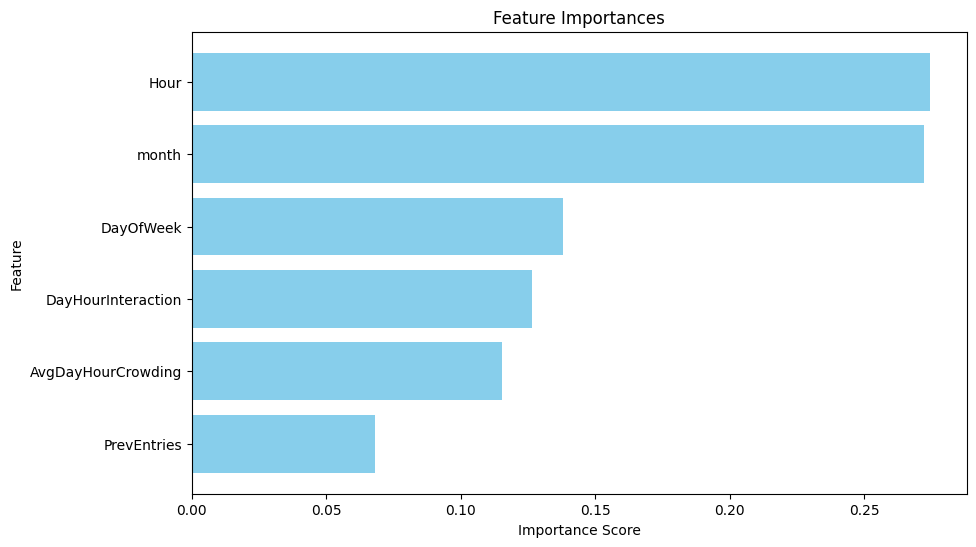

In [43]:
import matplotlib.pyplot as plt

# Generate feature importance data
feature_importance = {feature_list[i]: importance for i, importance in enumerate(importances)}
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:6]

# Separate features and their importances for plotting
features, importances = zip(*sorted_importance)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features on top
plt.show()


<ipython-input-44-4f555cf1c1ba>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', lw=2, label="Perfect Prediction")


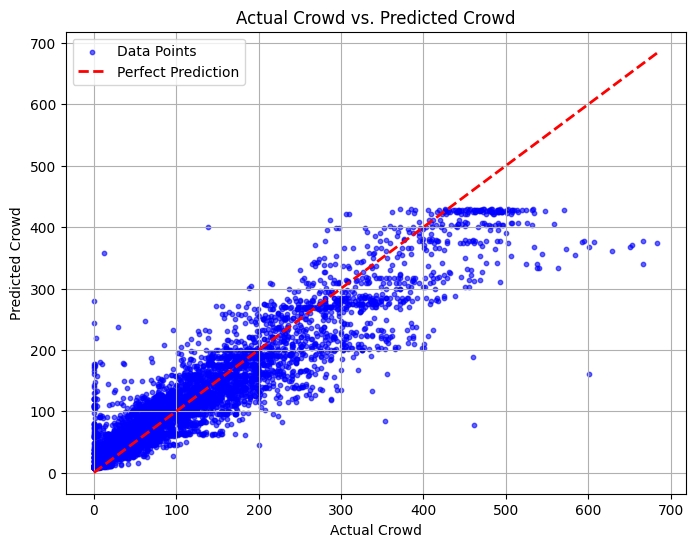

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col

# Ensure numeric data in PySpark DataFrame
predictions = predictions.withColumn("Crowding", col("Crowding").cast("float"))
predictions = predictions.withColumn("prediction", col("prediction").cast("float"))

# Convert to Python lists and then to NumPy arrays
y_test = np.array([row["Crowding"] for row in predictions.select("Crowding").collect()])
y_pred = np.array([row["prediction"] for row in predictions.select("prediction").collect()])

# Plot Predicted vs. Actuala
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, s=10 ,alpha=0.6, color='blue', label="Data Points")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', lw=2, label="Perfect Prediction")
plt.title('Actual Crowd vs. Predicted Crowd')
plt.xlabel('Actual Crowd')
plt.ylabel('Predicted Crowd')
plt.legend()
plt.grid(True)
plt.show()